In [1]:
!pip install split-folders

^C


In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout, MaxPool2D
from keras.layers import BatchNormalization


import tensorflow_hub as hub
import datetime
import time
# for the evaluation
%load_ext tensorboard

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
import zipfile
zipp=zipfile.ZipFile("/content/drive/MyDrive/Data/archive (7).zip",'r')
zipp.extractall('files')
zipp.close()

In [ ]:
path='/content/files/images/Images'
sub_dir=os.listdir(path)
print(len(sub_dir))
classes=len(sub_dir)
print(sub_dir[:13])

120

['n02088094-Afghan_hound', 'n02112137-chow', 'n02110806-basenji', 'n02106166-Border_collie', 'n02096294-Australian_terrier', 'n02087046-toy_terrier', 'n02097047-miniature_schnauzer', 'n02110185-Siberian_husky', 'n02093991-Irish_terrier', 'n02090622-borzoi', 'n02097209-standard_schnauzer', 'n02088364-beagle', 'n02109961-Eskimo_dog']


In [ ]:
for dirpath,dirnames,filenames in os.walk('/content/files/images'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 1 directories and 0 images in '/content/files/images'.

There are 120 directories and 0 images in '/content/files/images/Images'.

There are 0 directories and 239 images in '/content/files/images/Images/n02088094-Afghan_hound'.

There are 0 directories and 196 images in '/content/files/images/Images/n02112137-chow'.

There are 0 directories and 209 images in '/content/files/images/Images/n02110806-basenji'.

There are 0 directories and 150 images in '/content/files/images/Images/n02106166-Border_collie'.

There are 0 directories and 196 images in '/content/files/images/Images/n02096294-Australian_terrier'.

There are 0 directories and 172 images in '/content/files/images/Images/n02087046-toy_terrier'.

There are 0 directories and 154 images in '/content/files/images/Images/n02097047-miniature_schnauzer'.

There are 0 directories and 192 images in '/content/files/images/Images/n02110185-Siberian_husky'.

There are 0 directories and 169 images in '/content/files/images/Images/n

In [ ]:
import pathlib
data_dir=pathlib.Path('/content/files/images/Images')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
cls=[item.name for item in data_dir.glob('*')]
print(cls)
len(cls)

['n02088094-Afghan_hound', 'n02112137-chow', 'n02110806-basenji', 'n02106166-Border_collie', 'n02096294-Australian_terrier', 'n02087046-toy_terrier', 'n02097047-miniature_schnauzer', 'n02110185-Siberian_husky', 'n02093991-Irish_terrier', 'n02090622-borzoi', 'n02097209-standard_schnauzer', 'n02088364-beagle', 'n02109961-Eskimo_dog', 'n02093428-American_Staffordshire_terrier', 'n02109525-Saint_Bernard', 'n02102318-cocker_spaniel', 'n02108000-EntleBucher', 'n02099429-curly-coated_retriever', 'n02102480-Sussex_spaniel', 'n02094433-Yorkshire_terrier', 'n02086910-papillon', 'n02085620-Chihuahua', 'n02086240-Shih-Tzu', 'n02104365-schipperke', 'n02105505-komondor', 'n02108089-boxer', 'n02085936-Maltese_dog', 'n02107142-Doberman', 'n02108422-bull_mastiff', 'n02091244-Ibizan_hound', 'n02107683-Bernese_mountain_dog', 'n02113712-miniature_poodle', 'n02115913-dhole', 'n02097130-giant_schnauzer', 'n02090379-redbone', 'n02085782-Japanese_spaniel', 'n02116738-African_hunting_dog', 'n02091134-whippet',

120

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

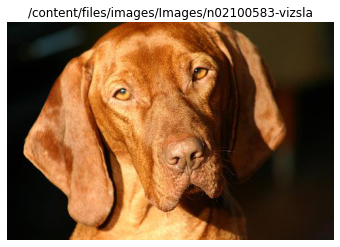

In [ ]:
def show_random_image(target_dir):
  for i in range (len(cls)):
     target_folder=target_dir+cls[i]
     random_image=random.sample(os.listdir(target_folder),1)
     img = mpimg.imread(target_folder + "/" + random_image[0])
     plt.imshow(img)
     plt.title(target_folder)
     plt.axis("off");
     #print(f"Image shape: {img.shape}")


  return img

img=show_random_image(target_dir="/content/files/images/Images/")


In [ ]:
import splitfolders
splitfolders.ratio("/content/files/images/Images", # The location of dataset
                   output="/content/files/Imgg", # The output location
                   seed=42, # The number of seed
                   ratio=(.7, .2, .1), # The ratio of splited dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )

Copying files: 20580 files [00:04, 4710.31 files/s]


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)
train_dir='/content/files/Imgg/train'
val_dir='/content/files/Imgg/val'
test_dir='/content/files/Imgg/test'
# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical') # changed to categorical

test_data = train_datagen.flow_from_directory(val_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 14355 images belonging to 120 classes.

Found 4072 images belonging to 120 classes.


In [ ]:
len(train_dir),len(val_dir),len(test_dir)

(25, 23, 24)

In [ ]:
feature_extractor_model = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4' 
feature_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224,224,3),
    trainable=False)
num_classes = classes

In [ ]:
import tensorflow as tf


model = tf.keras.Sequential([
    feature_layer,
    tf.keras.layers.Dense(classes, activation='softmax')])
model.summary()

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   

                                                                 

 dense (Dense)               (None, 120)               153720    

                                                                 


Total params: 2,411,704

Trainable params: 153,720

Non-trainable params: 2,257,984

_________________________________________________________________


In [ ]:
import tensorflow as tf
model.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history = model.fit(train_data, epochs=3)

Epoch 1/3

449/449 [==============================] - 72s 137ms/step - loss: 1.1972 - accuracy: 0.6963

Epoch 2/3

449/449 [==============================] - 59s 131ms/step - loss: 0.4288 - accuracy: 0.8714

Epoch 3/3

449/449 [==============================] - 58s 129ms/step - loss: 0.2780 - accuracy: 0.9249


In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [ ]:
plot_loss_curves(history)

KeyError: ignored

In [ ]:
image='/content/sample_data/Basenji_Profile_(loosercrop).jpg'


predicted_batch = model.predict(image)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label = classes[predicted_id]
plt.figure(figsize=(10,7))
plt.subplots_adjust(hspace=0.5)
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(image[i])
  plt.title(predicted_label[i].title())
  plt.axis('off')
  plt.tight_layout
  plt.suptitle('Model predictions')

IndexError: ignored